In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 40)

# Use this to see how much memory the dataframes use
from sys import getsizeof

from vivarium_research_prl import datatypes
from vivarium_research_prl.noise import corruption, fake_names, noisify
from vivarium_research_prl.find_kids import datasets, noisify_data

!date
!whoami
!uname -a
!pwd

Tue 07 Mar 2023 09:46:55 PM PST
ndbs
Linux int-slurm-sarchive-p0002 5.4.0-135-generic #152-Ubuntu SMP Wed Nov 23 20:19:22 UTC 2022 x86_64 x86_64 x86_64 GNU/Linux
/mnt/share/code/ndbs/vivarium_research_prl/model_validation


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
np.log2(1024**2)

20.0

In [4]:
1<<20

1048576

In [5]:
def sizemb(obj, mib=False):
    mb = 1024**2 if mib else 1e6
    return getsizeof(obj) / mb

# Load HDF files that I created

In [17]:
prl_data_dir = '/share/scratch/users/ndbs/prl'
data_subdir = '2023_02_27_10_25_20'

data_dir = f'{prl_data_dir}/{data_subdir}'

!ls -halt $data_dir

total 612M
drwxrwxr-x 2 ndbs Domain Users 1.0K Mar  7 22:00 .
drwxrwxr-x 3 ndbs Domain Users 1.0K Mar  7 21:55 ..
-rw-rw-r-- 1 ndbs IHME-users    59M Mar  7 17:40 wic.hdf
-rw-rw-r-- 1 ndbs IHME-users   554M Mar  7 15:43 decennial_census.hdf


In [9]:
%%time
df_census = pd.read_hdf(f'{data_dir}/decennial_census.hdf')
df_census

CPU times: user 1min 7s, sys: 2.73 s, total: 1min 10s
Wall time: 1min 11s


,simulant_id,first_name_id,middle_name_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,state_id,...,street_name,unit_number,city,mailing_address_street_number,mailing_address_street_name,mailing_address_unit_number,mailing_address_po_box,mailing_address_state,mailing_address_city,mailing_address_zipcode
0,3254000000000,3254000000000,3254000000000,3254000000000,59.550114,Male,White,1960-09-12,3254000000006,25,...,cliffside dr,NaN,billerica,NaN,cliffside dr,NaN,0,MA,billerica,2740
1,3254000000001,3254000000001,3254000000001,3254000000000,58.674889,Female,White,1961-07-29,3254000000006,25,...,cliffside dr,NaN,billerica,NaN,cliffside dr,NaN,0,MA,billerica,2740
2,3254000000002,3254000000002,3254000000002,3254000000002,53.272919,Male,White,1966-12-23,3254000000007,55,...,108th ave se,NaN,milwaukee,14323,108th ave se,NaN,0,WI,milwaukee,53952
3,3254000000003,3254000000003,3254000000003,3254000000002,54.643021,Female,White,1965-08-10,3254000000007,55,...,108th ave se,NaN,milwaukee,14323,108th ave se,NaN,0,WI,milwaukee,53952
4,3254000000004,3254000000004,3254000000004,3254000000004,55.642822,Female,Black,1964-08-09,3254000000008,24,...,ne 7th ave,NaN,nrt beach,358,ne 7th ave,NaN,0,MD,nrt beach,21239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15448912,3541000883506,3541000883506,3541000883506,3541000883504,7.739110,Male,White,2022-07-21,3541000618378,6,...,lone wolf dr,NaN,tulare,NaN,NaN,NaN,4657,CA,san diego,95136
15448913,3541000883507,3541000883507,3541000883507,3541000883504,31.564119,Female,White,1998-09-23,3541000618378,6,...,lone wolf dr,NaN,tulare,NaN,NaN,NaN,4657,CA,san diego,95136
15448914,3541000883508,3541000883508,3541000883508,3541000883508,27.369617,Male,Latino,2002-12-03,3541000618379,37,...,old silo rd,NaN,mooresville,1780,old silo rd,NaN,0,NC,mooresville,27217
15448915,3541000883509,3541000883509,3541000883509,3541000883509,71.134048,Male,Asian,1959-02-27,3541000618380,6,...,blue rdge ave,NaN,visalia,565,blue rdge ave,NaN,0,CA,visalia,91770


In [11]:
sizemb(df_census), sizemb(df_census, True)

(2248.774366, 2144.5983562469482)

# Save different years under different keys in a new file to make loading faster if you only want one year

In [12]:
df_census.census_year.unique()

['2020', '2030']
Categories (2, object): ['2020', '2030']

In [13]:
df_census.census_year.value_counts()

2030    7945099
2020    7503818
Name: census_year, dtype: int64

In [14]:
df_census.loc[df_census.census_year=='2030']

,simulant_id,first_name_id,middle_name_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,state_id,...,street_name,unit_number,city,mailing_address_street_number,mailing_address_street_name,mailing_address_unit_number,mailing_address_po_box,mailing_address_state,mailing_address_city,mailing_address_zipcode
750337,3254000000000,3254000000000,3254000000000,3254000000000,69.515892,Male,White,1960-09-12,3254000000006,25,...,cliffside dr,NaN,billerica,NaN,cliffside dr,NaN,0,MA,billerica,2740
750338,3254000000001,3254000000001,3254000000001,3254000000000,68.640663,Female,White,1961-07-29,3254000000006,25,...,cliffside dr,NaN,billerica,NaN,cliffside dr,NaN,0,MA,billerica,2740
750339,3254000000002,3254000000002,3254000000002,3254000000002,63.238697,Male,White,1966-12-23,3254000443431,4,...,feller rd,NaN,gilbert,13,feller rd,NaN,0,AZ,gilbert,85301
750340,3254000000003,3254000000003,3254000000003,3254000000002,64.608795,Female,White,1965-08-10,3254000443431,4,...,feller rd,NaN,gilbert,13,feller rd,NaN,0,AZ,gilbert,85301
750341,3254000000004,3254000000004,3254000000004,3254000000004,65.608597,Female,Black,1964-08-09,3254000305225,37,...,bernardo de galvez,NaN,charlotte,2153,bernardo de galvez,NaN,0,NC,charlotte,28469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15448912,3541000883506,3541000883506,3541000883506,3541000883504,7.739110,Male,White,2022-07-21,3541000618378,6,...,lone wolf dr,NaN,tulare,NaN,NaN,NaN,4657,CA,san diego,95136
15448913,3541000883507,3541000883507,3541000883507,3541000883504,31.564119,Female,White,1998-09-23,3541000618378,6,...,lone wolf dr,NaN,tulare,NaN,NaN,NaN,4657,CA,san diego,95136
15448914,3541000883508,3541000883508,3541000883508,3541000883508,27.369617,Male,Latino,2002-12-03,3541000618379,37,...,old silo rd,NaN,mooresville,1780,old silo rd,NaN,0,NC,mooresville,27217
15448915,3541000883509,3541000883509,3541000883509,3541000883509,71.134048,Male,Asian,1959-02-27,3541000618380,6,...,blue rdge ave,NaN,visalia,565,blue rdge ave,NaN,0,CA,visalia,91770


In [15]:
for i in [1,2]:
    %time np.full(i, 100**2)

CPU times: user 62 µs, sys: 5 µs, total: 67 µs
Wall time: 73.4 µs
CPU times: user 52 µs, sys: 0 ns, total: 52 µs
Wall time: 58.4 µs


In [31]:
%%time

census_by_year_path = f'{data_dir}/decennial_census_by_year.hdf'

for year in ['2020', '2030']:
    print(year)
    %time df_census.loc[df_census.census_year==year].to_hdf( \
        census_by_year_path, key=f'year_{year}', \
        format='table', \
        complevel=5, complib='bzip2' \
    )

!ls -halt $data_dir

2020
CPU times: user 1min 25s, sys: 751 ms, total: 1min 26s
Wall time: 1min 27s
2030
CPU times: user 1min 39s, sys: 784 ms, total: 1min 39s
Wall time: 1min 40s
total 1.2G
-rw-rw-r-- 1 ndbs Domain Users 610M Mar  7 22:48 decennial_census_by_year.hdf
drwxrwxr-x 2 ndbs Domain Users 1.5K Mar  7 22:48 .
drwxrwxr-x 3 ndbs Domain Users 1.0K Mar  7 21:55 ..
-rw-rw-r-- 1 ndbs IHME-users    59M Mar  7 17:40 wic.hdf
-rw-rw-r-- 1 ndbs IHME-users   554M Mar  7 15:43 decennial_census.hdf
CPU times: user 3min 4s, sys: 1.57 s, total: 3min 5s
Wall time: 3min 8s


In [32]:
%%time
with pd.HDFStore(census_by_year_path) as hdf:
    print(hdf.info())
    hdf_keys = hdf.keys()

<class 'pandas.io.pytables.HDFStore'>
File path: /share/scratch/users/ndbs/prl//2023_02_27_10_25_20/decennial_census_by_year.hdf
/year_2020                                      frame_table  (typ->appendable,nrows->7503818,ncols->37,indexers->[index],dc->[])     
/year_2020/meta/values_block_10/meta            series_table (typ->appendable,nrows->2,ncols->1,indexers->[index],dc->[values])      
/year_2020/meta/values_block_11/meta            series_table (typ->appendable,nrows->7,ncols->1,indexers->[index],dc->[values])      
/year_2020/meta/values_block_12/meta            series_table (typ->appendable,nrows->110,ncols->1,indexers->[index],dc->[values])    
/year_2020/meta/values_block_13/meta            series_table (typ->appendable,nrows->51,ncols->1,indexers->[index],dc->[values])     
/year_2020/meta/values_block_14/meta            series_table (typ->appendable,nrows->20197,ncols->1,indexers->[index],dc->[values])  
/year_2020/meta/values_block_15/meta            series_table (typ->

In [33]:
hdf_keys

['/year_2020',
 '/year_2030',
 '/year_2030/meta/values_block_9/meta',
 '/year_2030/meta/values_block_6/meta',
 '/year_2030/meta/values_block_4/meta',
 '/year_2030/meta/values_block_3/meta',
 '/year_2030/meta/values_block_28/meta',
 '/year_2030/meta/values_block_27/meta',
 '/year_2030/meta/values_block_26/meta',
 '/year_2030/meta/values_block_25/meta',
 '/year_2030/meta/values_block_24/meta',
 '/year_2030/meta/values_block_23/meta',
 '/year_2030/meta/values_block_22/meta',
 '/year_2030/meta/values_block_21/meta',
 '/year_2030/meta/values_block_20/meta',
 '/year_2030/meta/values_block_2/meta',
 '/year_2030/meta/values_block_19/meta',
 '/year_2030/meta/values_block_18/meta',
 '/year_2030/meta/values_block_17/meta',
 '/year_2030/meta/values_block_16/meta',
 '/year_2030/meta/values_block_15/meta',
 '/year_2030/meta/values_block_14/meta',
 '/year_2030/meta/values_block_13/meta',
 '/year_2030/meta/values_block_12/meta',
 '/year_2030/meta/values_block_11/meta',
 '/year_2030/meta/values_block_1

In [34]:
pd.read_hdf(census_by_year_path, '/year_2020/meta/values_block_10/meta')

0    2020
1    2030
dtype: object

In [35]:
pd.read_hdf(census_by_year_path, '/year_2020/meta/values_block_17/meta')

0        10003
1        10009
2         1001
3        10010
4        10011
         ...  
32129    59461
32130    60969
32131    69036
32132    97911
32133    71998
Length: 32134, dtype: object

# Read in WIC data

In [36]:
%%time
df_wic = pd.read_hdf(f'{data_dir}/wic.hdf')
df_wic

CPU times: user 5.57 s, sys: 75.8 ms, total: 5.65 s
Wall time: 5.92 s


,simulant_id,first_name_id,middle_name_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,state_id,...,street_name,unit_number,city,mailing_address_street_number,mailing_address_street_name,mailing_address_unit_number,mailing_address_po_box,mailing_address_state,mailing_address_city,mailing_address_zipcode
0,7359000000037,7359000000037,7359000000037,7359000000036,21.328291,Female,White,1999-08-12,7359000000022,39,...,navy,NaN,struthers,37,navy,NaN,0,OH,struthers,45656
1,7359000000534,7359000000534,7359000000534,7359000000534,28.912081,Female,Latino,1992-01-11,7359000000222,48,...,lynbrook road,NaN,midland,1135,lynbrook road,NaN,0,TX,midland,77901
2,7359000000587,7359000000587,7359000000587,7359000000587,39.129105,Female,White,1981-10-23,7359000000238,6,...,almeda rd,NaN,berkeley,3631,almeda rd,NaN,0,CA,berkeley,91101
3,7359000000668,7359000000668,7359000000668,7359000000668,28.240271,Female,Latino,1992-09-12,7359000000266,6,...,fremont,NaN,murray,5900,fremont,NaN,0,CA,murray,93702
4,7359000001174,7359000001174,7359000001174,7359000001174,24.146772,Female,White,1996-10-16,7359000000476,17,...,brickett st,number 532,niles,1343,brickett st,number 532,0,IL,niles,60625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117386,5020000880494,5020000880494,5020000880494,5020000564117,0.028075,Female,Black,2030-01-13,5020000459053,39,...,james manor st,NaN,toledo,2640,james manor st,NaN,0,OH,toledo,44281
1117387,5020000880496,5020000880496,5020000880496,5020000595381,0.044600,Female,Latino,2030-01-07,5020000529146,35,...,huckleberry rd,NaN,albuquerque,10178,huckleberry rd,NaN,0,NM,albuquerque,87110
1117388,5020000880497,5020000880497,5020000880497,5020000618655,0.074165,Male,Latino,2029-12-27,5020000603095,6,...,forest ave,NaN,la verne,821,forest ave,NaN,0,CA,la verne,92101
1117389,5020000880499,5020000880499,5020000880499,5020000658640,0.031057,Female,White,2030-01-12,5020000446941,21,...,raleigh st,NaN,louisville,3636,raleigh st,NaN,0,KY,louisville,40160


In [37]:
sizemb(df_wic), sizemb(df_wic, True)

(215.807903, 205.8104543685913)

In [38]:
df_wic.dtypes

simulant_id                         int64
first_name_id                       int64
middle_name_id                      int64
last_name_id                        int64
age                               float32
sex                              category
race_ethnicity                   category
date_of_birth                    category
address_id                          int64
state_id                             int8
po_box                           category
puma                                int16
guardian_1                          int32
guardian_2                          int32
guardian_1_address_id             float32
guardian_2_address_id             float32
wic_year                         category
random_seed                          int8
year_of_birth                    category
state                            category
first_name                       category
middle_initial                   category
last_name                        category
zipcode                          c

# Get separate views of 2020 and 2030 censuses

In [39]:
%%time
df_c2020 = df_census.loc[df_census.census_year=='2020']
df_c2030 = df_census.loc[df_census.census_year=='2030']

CPU times: user 1.91 s, sys: 428 ms, total: 2.34 s
Wall time: 2.33 s


# Start looking into data

In [40]:
df_wic.wic_year.unique()

['2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030']
Categories (10, object): ['2021', '2022', '2023', '2024', ..., '2027', '2028', '2029', '2030']

# Try to plot Abie's graph

In [42]:
df_wic.wic_year[0]

'2021'

In [44]:
df_wic.year_of_birth[0]

'1999'

In [45]:
c = pd.Categorical([1,2,3,4,5])
c

[1, 2, 3, 4, 5]
Categories (5, int64): [1, 2, 3, 4, 5]

In [46]:
c+3

TypeError: unsupported operand type(s) for +: 'Categorical' and 'int'

In [47]:
s = pd.Categorical(list('aldksjfj'))
s

['a', 'l', 'd', 'k', 's', 'j', 'f', 'j']
Categories (7, object): ['a', 'd', 'f', 'j', 'k', 'l', 's']

In [48]:
s+'g'

TypeError: unsupported operand type(s) for +: 'Categorical' and 'str'

In [49]:
isinstance(c, pd.Series)

False

In [51]:
ss = pd.Series(list('aldksjfj'))
isinstance(ss, pd.Series)

True

In [52]:
isinstance(ss.astype('category'), pd.Series)

True

In [55]:
ss.astype('category')

0    a
1    l
2    d
3    k
4    s
5    j
6    f
7    j
dtype: category
Categories (7, object): ['a', 'd', 'f', 'j', 'k', 'l', 's']

In [57]:
isinstance(df_wic.sex, pd.Series)

True

In [69]:
sc = ss.astype('category')
sc

0    a
1    l
2    d
3    k
4    s
5    j
6    f
7    j
dtype: category
Categories (7, object): ['a', 'd', 'f', 'j', 'k', 'l', 's']

In [70]:
sc[1] = np.nan

In [71]:
sc

0      a
1    NaN
2      d
3      k
4      s
5      j
6      f
7      j
dtype: category
Categories (7, object): ['a', 'd', 'f', 'j', 'k', 'l', 's']

In [62]:
sc[2] = 'z'

TypeError: Cannot setitem on a Categorical with a new category (z), set the categories first

In [72]:
sc.cat.add_categories('z')

0      a
1    NaN
2      d
3      k
4      s
5      j
6      f
7      j
dtype: category
Categories (8, object): ['a', 'd', 'f', 'j', 'k', 'l', 's', 'z']

In [73]:
sc

0      a
1    NaN
2      d
3      k
4      s
5      j
6      f
7      j
dtype: category
Categories (7, object): ['a', 'd', 'f', 'j', 'k', 'l', 's']

# Try plotting Abie's graph of births in each year

In [74]:
2**16

65536

In [78]:
df_wic.year_of_birth.astype('int16')

0          1999
1          1992
2          1981
3          1992
4          1996
           ... 
1117386    2030
1117387    2030
1117388    2029
1117389    2030
1117390    2029
Name: year_of_birth, Length: 1117391, dtype: int16

In [106]:
birth_counts_by_year2030 = df_c2030.year_of_birth.astype('int16').value_counts().sort_index()
birth_counts_by_year2030

1921        3
1922       37
1923      186
1924      587
1925      889
        ...  
2026    92358
2027    91176
2028    92339
2029    92191
2030    26698
Name: year_of_birth, Length: 110, dtype: int64

In [103]:
birth_counts_by_year2020 = df_c2020.year_of_birth.astype('int16').value_counts().sort_index()
birth_counts_by_year2020

1921       55
1922      611
1923     3075
1924     8417
1925    12516
        ...  
2016    88138
2017    86065
2018    79312
2019    61095
2020    46325
Name: year_of_birth, Length: 100, dtype: int64

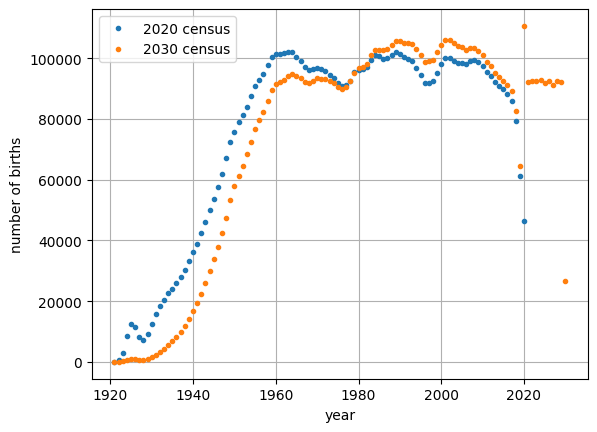

In [108]:
plt.plot(birth_counts_by_year2020.index, birth_counts_by_year2020, '.', label='2020 census')
plt.plot(birth_counts_by_year2030.index, birth_counts_by_year2030, '.', label='2030 census')
plt.xlabel('year')
plt.ylabel('number of births')
plt.legend()
plt.grid()

In [115]:
year_range

2010

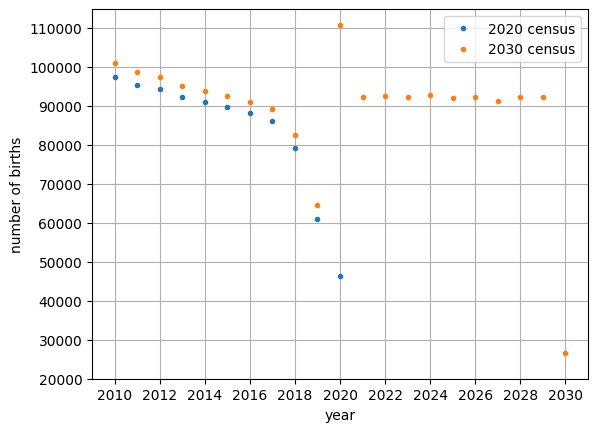

In [127]:
year_range = np.arange(2010, 2031)
year_range2020 = year_range[:-10]
plt.plot(year_range2020, birth_counts_by_year2020[year_range2020], '.', label='2020 census')
plt.plot(year_range, birth_counts_by_year2030[year_range], '.', label='2030 census')
plt.xticks(year_range[::2]);
plt.yticks(range(20_000, 120_000, 10_000))
plt.xlabel('year')
plt.ylabel('number of births')
plt.legend()
plt.grid()

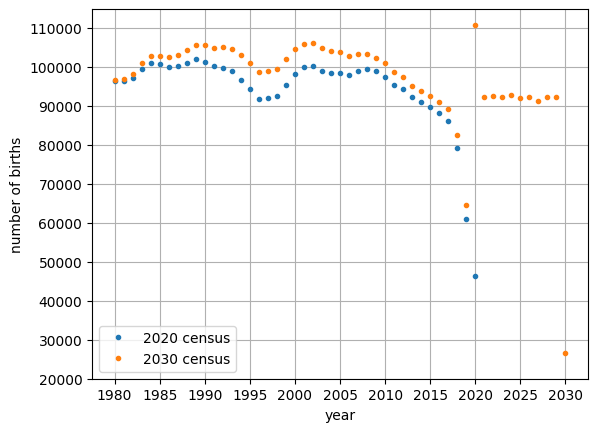

In [129]:
year_range = np.arange(1980, 2031)
year_range2020 = year_range[:-10]
plt.plot(year_range2020, birth_counts_by_year2020[year_range2020], '.', label='2020 census')
plt.plot(year_range, birth_counts_by_year2030[year_range], '.', label='2030 census')
plt.xticks(year_range[::5]);
plt.yticks(range(20000,120000,10000))
plt.xlabel('year')
plt.ylabel('number of births')
plt.legend()
plt.grid()

# See how many children in census and how many children in WIC are not in census

There are about 460,000 children under 5 in the 2030 census.

In [130]:
%%time
dfc2030_u5 = df_c2030.query("age < 5")
dfc2030_u5

CPU times: user 81.9 ms, sys: 59.8 ms, total: 142 ms
Wall time: 146 ms


,simulant_id,first_name_id,middle_name_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,state_id,...,street_name,unit_number,city,mailing_address_street_number,mailing_address_street_name,mailing_address_unit_number,mailing_address_po_box,mailing_address_state,mailing_address_city,mailing_address_zipcode
1477877,3254000816159,3254000816159,3254000816159,3254000001936,4.988009,Male,Latino,2025-04-22,3254000000794,32,...,whitehall way,NaN,spring crk trlr sec,917,whitehall way,NaN,0,NV,spring crk trlr sec,89119
1477878,3254000816160,3254000816160,3254000816160,3254000001955,4.997880,Male,White,2025-04-18,3254000335463,6,...,lake club ct,NaN,fresno,7136,lake club ct,NaN,0,CA,fresno,90018
1477886,3254000816168,3254000816168,3254000816168,3254000013036,4.997493,Female,White,2025-04-18,3254000005252,31,...,van dr,NaN,omaha,NaN,van dr,NaN,0,NE,omaha,68730
1477902,3254000816184,3254000816184,3254000816184,3254000032640,4.997196,Male,White,2025-04-18,3254000480074,6,...,burham st,NaN,los angeles,1456,burham st,NaN,0,CA,los angeles,91711
1477912,3254000816194,3254000816194,3254000816194,3254000039042,4.998860,Female,White,2025-04-18,3254000377396,12,...,madalyn ave,NaN,lehigh acres,3712,madalyn ave,NaN,0,FL,lehigh acres,33428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15448875,3541000883469,3541000883469,3541000883469,3541000883468,3.839186,Female,Black,2026-06-15,3541000618366,48,...,ithaca st,NaN,mineral wells,516,ithaca st,NaN,0,TX,mineral wells,77063
15448876,3541000883470,3541000883470,3541000883470,3541000883468,2.799510,Female,Black,2027-06-29,3541000618366,48,...,ithaca st,NaN,mineral wells,516,ithaca st,NaN,0,TX,mineral wells,77063
15448892,3541000883486,3541000883486,3541000883486,3541000883482,2.881101,Female,Black,2027-05-31,3541000618372,13,...,chestnut street,NaN,savannah,3148,chestnut street,NaN,0,GA,savannah,30907
15448903,3541000883497,3541000883497,3541000883497,3541000883490,3.349061,Male,Multiracial or Other,2026-12-11,3541000618375,36,...,boston rd,NaN,dewitt,610,boston rd,NaN,0,NY,dewitt,11219


In [131]:
len(dfc2030_u5) / len(df_c2030)

0.05786724621052551

In [132]:
2_000 / 50_000

0.04

In [133]:
dfc2030_u5.simulant_id.nunique()

459761

In [141]:
dfc2030_u5.date_of_birth.astype(str).max()

'2030-04-16'

In [143]:
dfc2030_u5.date_of_birth

1477877     2025-04-22
1477878     2025-04-18
1477886     2025-04-18
1477902     2025-04-18
1477912     2025-04-18
               ...    
15448875    2026-06-15
15448876    2027-06-29
15448892    2027-05-31
15448903    2026-12-11
15448909    2025-08-06
Name: date_of_birth, Length: 459761, dtype: category
Categories (39499, object): ['1922-08-19', '1922-10-07', '1923-10-04', '1923-11-28', ..., '1922-11-23', '1921-08-30', '1922-05-05', '1922-06-13']

In [136]:
df_wic2030 = df_wic.loc[df_wic.wic_year=='2030']
df_wic2030

,simulant_id,first_name_id,middle_name_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,state_id,...,street_name,unit_number,city,mailing_address_street_number,mailing_address_street_name,mailing_address_unit_number,mailing_address_po_box,mailing_address_state,mailing_address_city,mailing_address_zipcode
101692,7359000000073,7359000000073,7359000000073,7359000000072,39.912498,Female,Black,1990-01-27,7359000598851,12,...,duenda rd,NaN,lakeland,3200,duenda rd,NaN,0,FL,lakeland,33432
101693,7359000000412,7359000000412,7359000000412,7359000000410,20.518253,Female,Latino,2009-06-20,7359000537939,8,...,s locust,NaN,fruita,28750,s locust,NaN,0,CO,fruita,80014
101694,7359000000849,7359000000849,7359000000849,7359000000849,34.801800,Female,Latino,1995-03-09,7359000569897,12,...,good street,NaN,dade city,11911,good street,NaN,0,FL,dade city,32826
101695,7359000000942,7359000000942,7359000000942,7359000000941,25.598354,Female,Latino,2004-05-21,7359000000378,48,...,clark street,NaN,cedar park,3818,clark street,NaN,0,TX,cedar park,78741
101696,7359000001926,7359000001926,7359000001926,7359000001926,27.443308,Female,Black,2002-07-17,7359000509798,27,...,fairburn raod nw,# 405,city of dellwood,171,fairburn raod nw,# 405,0,MN,city of dellwood,55119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117386,5020000880494,5020000880494,5020000880494,5020000564117,0.028075,Female,Black,2030-01-13,5020000459053,39,...,james manor st,NaN,toledo,2640,james manor st,NaN,0,OH,toledo,44281
1117387,5020000880496,5020000880496,5020000880496,5020000595381,0.044600,Female,Latino,2030-01-07,5020000529146,35,...,huckleberry rd,NaN,albuquerque,10178,huckleberry rd,NaN,0,NM,albuquerque,87110
1117388,5020000880497,5020000880497,5020000880497,5020000618655,0.074165,Male,Latino,2029-12-27,5020000603095,6,...,forest ave,NaN,la verne,821,forest ave,NaN,0,CA,la verne,92101
1117389,5020000880499,5020000880499,5020000880499,5020000658640,0.031057,Female,White,2030-01-12,5020000446941,21,...,raleigh st,NaN,louisville,3636,raleigh st,NaN,0,KY,louisville,40160


In [155]:
wic2030_dob = pd.to_datetime(df_wic2030.date_of_birth)
wic2030_dob

101692    1990-01-27
101693    2009-06-20
101694    1995-03-09
101695    2004-05-21
101696    2002-07-17
             ...    
1117386   2030-01-13
1117387   2030-01-07
1117388   2029-12-27
1117389   2030-01-12
1117390   2029-03-27
Name: date_of_birth, Length: 108417, dtype: datetime64[ns]

In [150]:
wic2030_dob.max() # Why are there no younger kids?

Timestamp('2030-01-22 00:00:00')

<AxesSubplot: >

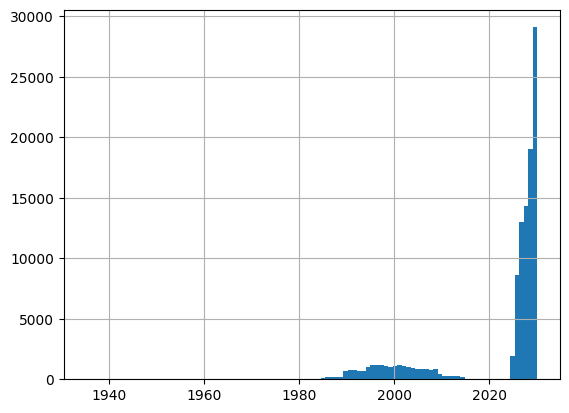

In [146]:
wic2030_dob.hist(bins=100)

In [153]:
pd.to_timedelta(df_wic2030.age*365.25, 'D')

101692    14578 days 00:57:39.374956800
101693     7494 days 07:00:28.125043200
101694       12711 days 08:34:41.250000
101695        9349 days 19:10:18.750000
101696       10023 days 16:01:52.500000
                       ...             
1117386         10 days 06:06:24.713712
1117387      16 days 06:57:35.090294400
1117388      27 days 02:07:34.888886400
1117389      11 days 08:14:32.067225600
1117390     301 days 15:22:37.910179200
Name: age, Length: 108417, dtype: timedelta64[ns]

In [244]:
wic2030_record_dates = wic2030_dob + pd.to_timedelta(df_wic2030.age*365.25, 'D')
wic2030_record_dates.rename('approx_record_date', inplace=True)
wic2030_record_dates

101692    2029-12-26 00:57:39.374956800
101693    2029-12-26 07:00:28.125043200
101694    2029-12-26 08:34:41.250000000
101695    2029-12-25 19:10:18.750000000
101696    2029-12-25 16:01:52.500000000
                       ...             
1117386   2030-01-23 06:06:24.713712000
1117387   2030-01-23 06:57:35.090294400
1117388   2030-01-23 02:07:34.888886400
1117389   2030-01-23 08:14:32.067225600
1117390   2030-01-22 15:22:37.910179200
Name: approx_record_date, Length: 108417, dtype: datetime64[ns]

In [245]:
wic2030_record_dates.dt.date.value_counts()

2030-01-23    86497
2029-12-26    10582
2029-12-25    10445
2030-01-22      893
Name: approx_record_date, dtype: int64

In [247]:
(
    df_wic2030
    .join(wic2030_record_dates.dt.date)
    .groupby('approx_record_date')
    [['age']]
    .describe()
)

age                                              \
                      count       mean        std        min        25%   
approx_record_date                                                        
2029-12-25          10445.0  30.255608   6.758758  10.840688  25.208834   
2029-12-26          10582.0  30.258316   6.789258  10.461503  25.288109   
2030-01-22            893.0  23.719200  12.751370   0.171240  15.985155   
2030-01-23          86497.0   2.128501   2.922803   0.002752   0.710295   

                                                     
                          50%        75%        max  
approx_record_date                                   
2029-12-25          30.397558  35.103683  85.598289  
2029-12-26          30.393578  35.091758  94.809929  
2030-01-22          27.887354  32.952492  48.091793  
2030-01-23           1.654945   3.028265  45.549644

# See how many simulants are in 2030 WIC but not 2030 census

Why are there only 58??

In [195]:
wic2030_not_census = set(df_wic2030.simulant_id).difference(df_c2030.simulant_id)
len(wic2030_not_census)

58

In [231]:
df_missing2030 = df_wic2030.query("simulant_id in @wic2030_not_census")
df_missing2030

,simulant_id,first_name_id,middle_name_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,state_id,...,street_name,unit_number,city,mailing_address_street_number,mailing_address_street_name,mailing_address_unit_number,mailing_address_po_box,mailing_address_state,mailing_address_city,mailing_address_zipcode
104820,7359000860757,7359000860757,7359000860757,7359000347941,1.477899,Male,Black,2028-08-02,7359000443267,18,...,sea gull dr,NaN,syracuse,1121,sea gull dr,NaN,0,IN,syracuse,47598
106513,7359000847364,7359000847364,7359000847364,7359000334173,2.500295,Female,White,2027-07-25,7359000412602,12,...,lunn's way,NaN,delray beach,34854,lunn's way,NaN,0,FL,delray beach,33009
108767,7359000816742,7359000816742,7359000816742,7359000526296,4.831631,Male,White,2025-03-26,7359000563658,48,...,waldron rd,NaN,mahomet,NaN,waldron rd,NaN,0,TX,mahomet,75220
109858,7359000869753,7359000869753,7359000869753,7359000188767,0.829871,Female,Latino,2029-03-26,7359000560748,49,...,3rd av,NaN,brigham city,2691,3rd av,NaN,0,UT,brigham city,84601
110021,7359000870222,7359000870222,7359000870222,7359000728275,0.803811,Female,White,2029-04-05,7359000567445,39,...,n beach rd,NaN,youngstown,11431,n beach rd,NaN,0,OH,youngstown,45302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004745,3254000879798,3254000879798,3254000879798,3254000377167,0.013720,Male,Black,2030-01-18,3254000151977,17,...,n 59th ln,NaN,prospect hgts,224,n 59th ln,NaN,0,IL,prospect hgts,60924
1107616,5020000362938,5020000362938,5020000362938,5020000362937,38.620491,Female,Black,1991-05-14,5020000145720,29,...,skyview dr,NaN,saint louis,36,skyview dr,NaN,0,MO,saint louis,63033
1108787,5020000861097,5020000861097,5020000861097,5020000331780,34.386234,Female,Latino,1995-09-04,5020000439061,6,...,talbot blvd,NaN,encinitas,25,talbot blvd,NaN,0,CA,encinitas,93636
1117299,5020000880217,5020000880217,5020000880217,5020000534076,0.016888,Male,White,2030-01-17,5020000084790,17,...,spruce street,NaN,chicago,12667,spruce street,NaN,0,IL,chicago,60010


<AxesSubplot: >

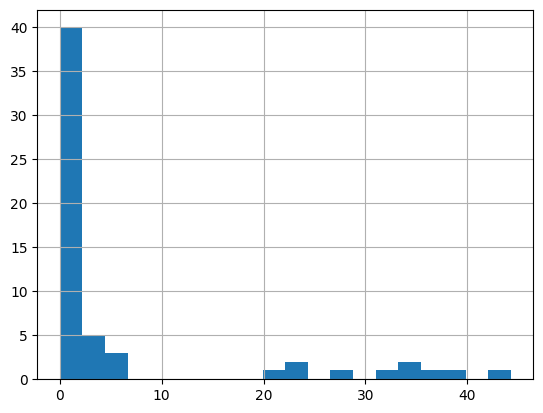

In [232]:
df_missing2030.age.hist(bins=20)

# Try renaming `wic_year` categories to make them integers

I want to specify an age range, and that will be easier with integers than with strings.

In [172]:
df_wic.wic_year

0          2021
1          2021
2          2021
3          2021
4          2021
           ... 
1117386    2030
1117387    2030
1117388    2030
1117389    2030
1117390    2030
Name: wic_year, Length: 1117391, dtype: category
Categories (10, object): ['2021', '2022', '2023', '2024', ..., '2027', '2028', '2029', '2030']

In [174]:
type(np.int16('2020'))

numpy.int16

In [185]:
%time df_wic.wic_year.cat.rename_categories(lambda year: int(year))

CPU times: user 1.16 ms, sys: 0 ns, total: 1.16 ms
Wall time: 952 µs


0          2021
1          2021
2          2021
3          2021
4          2021
           ... 
1117386    2030
1117387    2030
1117388    2030
1117389    2030
1117390    2030
Name: wic_year, Length: 1117391, dtype: category
Categories (10, int64): [2021, 2022, 2023, 2024, ..., 2027, 2028, 2029, 2030]

In [190]:
df_wic.wic_year.dtype == 'category'

True

In [191]:
%time df_wic['wic_year'] = df_wic.wic_year.cat.rename_categories(lambda year: int(year))

CPU times: user 3.48 ms, sys: 0 ns, total: 3.48 ms
Wall time: 2.91 ms


In [192]:
df_wic.wic_year

0          2021
1          2021
2          2021
3          2021
4          2021
           ... 
1117386    2030
1117387    2030
1117388    2030
1117389    2030
1117390    2030
Name: wic_year, Length: 1117391, dtype: category
Categories (10, int64): [2021, 2022, 2023, 2024, ..., 2027, 2028, 2029, 2030]

In [210]:
%time wic_year_str_cats = df_wic.wic_year.cat.rename_categories(lambda year: str(year))

CPU times: user 2.36 ms, sys: 80 µs, total: 2.44 ms
Wall time: 1.99 ms


In [213]:
%timeit wic_year_str_cats.cat.rename_categories(lambda year: int(year))
%timeit wic_year_str_cats.cat.rename_categories(wic_year_str_cats.cat.categories.astype(int))

346 µs ± 318 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
312 µs ± 145 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [193]:
sizemb(df_wic)

215.807373

# Now get last 5 years of WIC data and see how many simulants show up there but not in the 2030 census

Ok, 1686 total. That seems more reasonable, but why does the number start out as 736 in 2026 and then decrease by about 100-200 per year, ending at 58 in 2030?

In [198]:
df_wic5years = df_wic.loc[df_wic.wic_year.isin(range(2026,2031))]
df_wic5years

,simulant_id,first_name_id,middle_name_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,state_id,...,street_name,unit_number,city,mailing_address_street_number,mailing_address_street_name,mailing_address_unit_number,mailing_address_po_box,mailing_address_state,mailing_address_city,mailing_address_zipcode
57985,7359000000073,7359000000073,7359000000073,7359000000072,35.926189,Female,Black,1990-01-27,7359000431738,47,...,emory street,NaN,memphis,1120,emory street,NaN,0,TN,memphis,38106
57986,7359000000626,7359000000626,7359000000626,7359000000626,34.850002,Female,Black,1991-02-24,7359000370435,47,...,southeast rockwood str,NaN,germantown,112,southeast rockwood str,NaN,0,TN,germantown,37160
57987,7359000000668,7359000000668,7359000000668,7359000000668,33.299820,Female,Latino,1992-09-12,7359000475857,24,...,lanewood dr,basement apt # 516,snow hill,1600,lanewood dr,basement apt # 516,0,MD,snow hill,20901
57988,7359000001056,7359000001056,7359000001056,7359000001056,32.060780,Female,Latino,1993-12-09,7359000000428,48,...,myrick ln,NaN,georgetown,153,myrick ln,NaN,0,TX,georgetown,75501
57989,7359000001306,7359000001306,7359000001306,7359000001306,38.545238,Female,White,1987-06-15,7359000391829,48,...,stoneham wy,NaN,rio grande cty,416,stoneham wy,NaN,0,TX,rio grande cty,76201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117386,5020000880494,5020000880494,5020000880494,5020000564117,0.028075,Female,Black,2030-01-13,5020000459053,39,...,james manor st,NaN,toledo,2640,james manor st,NaN,0,OH,toledo,44281
1117387,5020000880496,5020000880496,5020000880496,5020000595381,0.044600,Female,Latino,2030-01-07,5020000529146,35,...,huckleberry rd,NaN,albuquerque,10178,huckleberry rd,NaN,0,NM,albuquerque,87110
1117388,5020000880497,5020000880497,5020000880497,5020000618655,0.074165,Male,Latino,2029-12-27,5020000603095,6,...,forest ave,NaN,la verne,821,forest ave,NaN,0,CA,la verne,92101
1117389,5020000880499,5020000880499,5020000880499,5020000658640,0.031057,Female,White,2030-01-12,5020000446941,21,...,raleigh st,NaN,louisville,3636,raleigh st,NaN,0,KY,louisville,40160


In [199]:
wic5years_not_census = set(df_wic5years.simulant_id).difference(df_c2030.simulant_id)
len(wic5years_not_census)

1686

In [205]:
df_missing5yr = df_wic5years.loc[df_wic5years.simulant_id.isin(wic5years_not_census)]
df_missing5yr

,simulant_id,first_name_id,middle_name_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,state_id,...,street_name,unit_number,city,mailing_address_street_number,mailing_address_street_name,mailing_address_unit_number,mailing_address_po_box,mailing_address_state,mailing_address_city,mailing_address_zipcode
58063,7359000033124,7359000033124,7359000033124,7359000033123,31.040619,Female,Latino,1994-12-16,7359000376790,19,...,marbrisa ave,NaN,dubuque,12500,marbrisa ave,NaN,0,IA,dubuque,50220
58069,7359000035740,7359000035740,7359000035740,7359000035737,22.452181,Female,White,2003-07-19,7359000163224,37,...,e 11th stre,NaN,mooresville,3439,e 11th stre,NaN,0,NC,mooresville,28352
58071,7359000036086,7359000036086,7359000036086,7359000036082,20.075014,Female,White,2005-12-04,7359000414532,37,...,corporate dr,NaN,mooresville,157-36,corporate dr,NaN,0,NC,mooresville,28806
58200,7359000081082,7359000081082,7359000081082,7359000081082,38.788242,Female,White,1987-03-19,7359000463792,51,...,winding cedar tl,NaN,wilsons,NaN,NaN,NaN,15916,VA,virginia beach,22551
58215,7359000086374,7359000086374,7359000086374,7359000086373,36.912113,Female,White,1989-02-01,7359000292948,39,...,snover road,NaN,dayton,102,snover road,NaN,0,OH,dayton,45344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106544,5020000866872,5020000866872,5020000866872,5020000576390,0.019426,Female,White,2029-01-17,5020000452802,36,...,w 17th ave,NaN,new york,143,w 17th ave,NaN,0,NY,new york,11215
1107616,5020000362938,5020000362938,5020000362938,5020000362937,38.620491,Female,Black,1991-05-14,5020000145720,29,...,skyview dr,NaN,saint louis,36,skyview dr,NaN,0,MO,saint louis,63033
1108787,5020000861097,5020000861097,5020000861097,5020000331780,34.386234,Female,Latino,1995-09-04,5020000439061,6,...,talbot blvd,NaN,encinitas,25,talbot blvd,NaN,0,CA,encinitas,93636
1117299,5020000880217,5020000880217,5020000880217,5020000534076,0.016888,Male,White,2030-01-17,5020000084790,17,...,spruce street,NaN,chicago,12667,spruce street,NaN,0,IL,chicago,60010


In [206]:
df_missing5yr.groupby('wic_year')['simulant_id'].nunique()

wic_year
2021      0
2022      0
2023      0
2024      0
2025      0
2026    736
2027    554
2028    381
2029    227
2030     58
Name: simulant_id, dtype: int64

<AxesSubplot: >

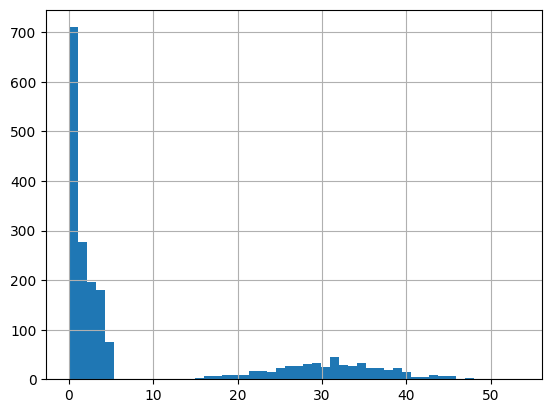

In [209]:
df_missing5yr.age.hist(bins=50)

# Do the same thing, but for all 10 years of WIC

In [249]:
wic_not_census = set(df_wic.simulant_id).difference(df_c2030.simulant_id)
len(wic_not_census)

6539

In [250]:
df_missing = df_wic.loc[df_wic.simulant_id.isin(wic_not_census)]
df_missing

,simulant_id,first_name_id,middle_name_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,state_id,...,street_name,unit_number,city,mailing_address_street_number,mailing_address_street_name,mailing_address_unit_number,mailing_address_po_box,mailing_address_state,mailing_address_city,mailing_address_zipcode
12,7359000003282,7359000003282,7359000003282,7359000003277,20.796120,Female,Latino,2000-02-22,7359000001334,6,...,e june st,NaN,torrance,533,e june st,NaN,0,CA,torrance,92844
49,7359000011217,7359000011217,7359000011217,7359000011215,26.621771,Female,Black,1994-04-26,7359000004502,39,...,the spout r,NaN,strasburg,8007,the spout r,NaN,0,OH,strasburg,44105
127,7359000030019,7359000030019,7359000030019,7359000030018,34.864712,Female,Black,1986-01-28,7359000012039,48,...,g113 e north st,NaN,humble,5355,g113 e north st,NaN,0,TX,humble,77449
199,7359000047711,7359000047711,7359000047711,7359000047711,25.800529,Female,Black,1995-02-20,7359000317423,29,...,moog rd,NaN,saint louis,4702,moog rd,NaN,0,MO,saint louis,64093
216,7359000051082,7359000051082,7359000051082,7359000051082,37.432510,Female,Latino,1983-07-05,7359000020598,9,...,manuel dr,unit # 3,central manchester,30862,manuel dr,unit # 3,0,CT,central manchester,6608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106544,5020000866872,5020000866872,5020000866872,5020000576390,0.019426,Female,White,2029-01-17,5020000452802,36,...,w 17th ave,NaN,new york,143,w 17th ave,NaN,0,NY,new york,11215
1107616,5020000362938,5020000362938,5020000362938,5020000362937,38.620491,Female,Black,1991-05-14,5020000145720,29,...,skyview dr,NaN,saint louis,36,skyview dr,NaN,0,MO,saint louis,63033
1108787,5020000861097,5020000861097,5020000861097,5020000331780,34.386234,Female,Latino,1995-09-04,5020000439061,6,...,talbot blvd,NaN,encinitas,25,talbot blvd,NaN,0,CA,encinitas,93636
1117299,5020000880217,5020000880217,5020000880217,5020000534076,0.016888,Male,White,2030-01-17,5020000084790,17,...,spruce street,NaN,chicago,12667,spruce street,NaN,0,IL,chicago,60010


In [257]:
missing_by_year = (
    df_missing.groupby('wic_year')['simulant_id'].nunique()
    .rename('Number missing in 2030 census')
)
missing_by_year

wic_year
2021    1876
2022    1471
2023    1236
2024    1101
2025     846
2026     736
2027     554
2028     381
2029     227
2030      58
Name: Number missing in 2030 census, dtype: int64

In [254]:
wic_enrollment = df_wic.groupby('wic_year')['simulant_id'].nunique()
wic_enrollment

wic_year
2021    124300
2022    113431
2023    111472
2024    112353
2025    111828
2026    108467
2027    109700
2028    108469
2029    108954
2030    108417
Name: simulant_id, dtype: int64

In [260]:
person_years = wic_enrollment * (2030+(4/12) - wic_enrollment.index.astype(int))
person_years

wic_year
2021    1.160133e+06
2022    9.452583e+05
2023    8.174613e+05
2024    7.115690e+05
2025    5.964160e+05
2026    4.700237e+05
2027    3.656667e+05
2028    2.530943e+05
2029    1.452720e+05
2030    3.613900e+04
dtype: float64

In [264]:
exit_rate = 100_000 * (missing_by_year / person_years).rename('exit_rate_per_100K_py')
exit_rate

wic_year
2021    161.705551
2022    155.618834
2023    151.199812
2024    154.728494
2025    141.847301
2026    156.587860
2027    151.504102
2028    150.536756
2029    156.258605
2030    160.491436
Name: exit_rate_per_100K_py, dtype: float64

# Count addresses per zipcode to compare with original FL data

In [216]:
%time addresses_per_zip = df_census.groupby('zipcode')['address_id'].nunique().sort_values()
addresses_per_zip

CPU times: user 3.45 s, sys: 312 ms, total: 3.76 s
Wall time: 3.76 s


zipcode
71998       1
45773       1
97911       1
79258       1
67953       1
         ... 
10025    1614
10467    1618
77449    1644
77084    1671
75034    1703
Name: address_id, Length: 32134, dtype: int64

Text(0, 0.5, 'Number of zipcodes falling in address density range')

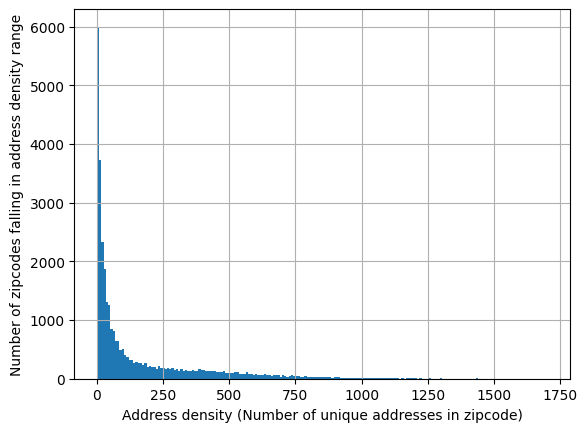

In [287]:
addresses_per_zip.hist(bins=200, density=False)
plt.xlabel("Address density (Number of unique addresses in zipcode)")
plt.ylabel("Number of zipcodes falling in address density range")

(0.0, 750.0)

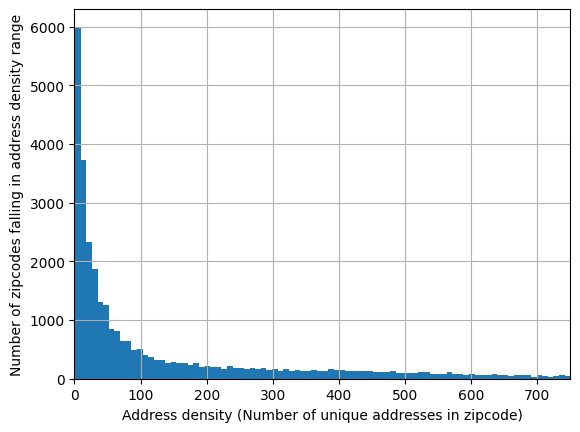

In [292]:
addresses_per_zip.hist(bins=200, density=False)
plt.xlabel("Address density (Number of unique addresses in zipcode)")
plt.ylabel("Number of zipcodes falling in address density range")
plt.xlim(0,750)

In [224]:
addresses_per_zip.describe()

count    32134.000000
mean       156.910282
std        223.133391
min          1.000000
25%         14.000000
50%         49.000000
75%        215.000000
max       1703.000000
Name: address_id, dtype: float64

In [276]:
%time simulants_per_zip2030 = (\
    df_c2030.groupby('zipcode', observed=True)['simulant_id'].nunique().sort_values()\
)
simulants_per_zip2030

CPU times: user 2.26 s, sys: 269 ms, total: 2.53 s
Wall time: 2.53 s


zipcode
88344        1
58549        1
98314        1
61468        1
88342        1
         ...  
75056    12474
92882    12527
11221    12687
10468    13006
11226    13285
Name: simulant_id, Length: 31828, dtype: int64

In [277]:
simulants_per_zip2030.index[0]

'88344'

In [278]:
df_c2030.loc[df_c2030.zipcode == '88344']

,simulant_id,first_name_id,middle_name_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,state_id,...,street_name,unit_number,city,mailing_address_street_number,mailing_address_street_name,mailing_address_unit_number,mailing_address_po_box,mailing_address_state,mailing_address_city,mailing_address_zipcode
15410338,3541000844483,3541000844483,3541000844483,3541000844483,24.540108,Male,White,2005-10-02,3541000526238,35,...,keezletown rd,NaN,albuquerque,1091,keezletown rd,NaN,0,NM,albuquerque,88344


In [279]:
simulants_per_zip2030.describe()

count    31828.000000
mean       249.626084
std        590.942310
min          1.000000
25%         20.000000
50%         72.000000
75%        315.000000
max      13285.000000
Name: simulant_id, dtype: float64

<AxesSubplot: >

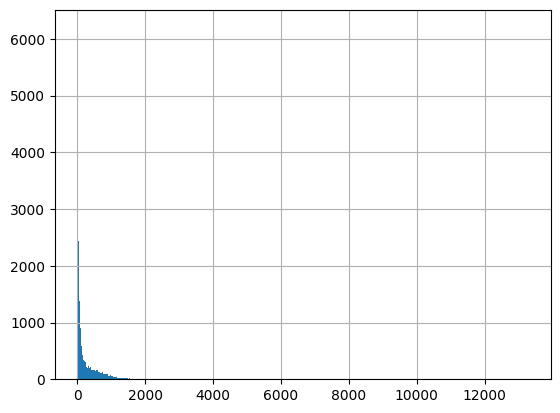

In [289]:
simulants_per_zip2030.hist(bins=1000)

(0.0, 750.0)

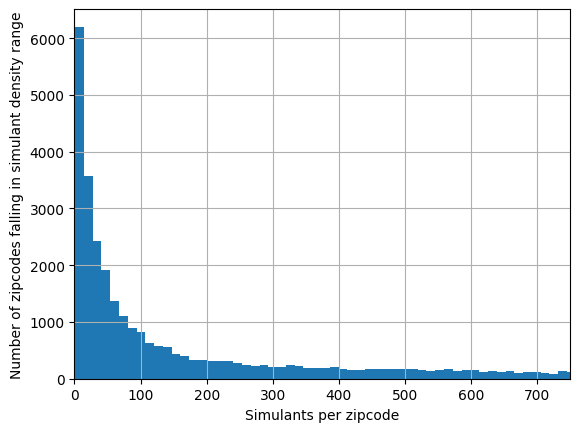

In [291]:
simulants_per_zip2030.hist(bins=1000)
plt.xlabel("Simulants per zipcode")
plt.ylabel("Number of zipcodes falling in simulant density range")
plt.xlim(0,750)